## Import Libraries

In [1]:
import pandas as pd
import geopandas as gpd
import fiona
import geopandas.geoseries  
import folium
import plotly.express as px
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx
from shapely import wkt

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


# Census Tract To Neighborhood Function
It takes census tract level geospatial data and dissolves it into neighborhood shapes. 
The arguments you need are your data frame (i.e. 'df= your data frame', your geometry column, usually named 'geometry' (i.e. "geometry='geometry'", and lastly how you want the variables to be summarized (i.e. 'sum' to add or 'mean' for an average)

In [2]:
def nhdissolve(df,geometry,math,skip=False):
    
    #Import neighborhood shapes
    url = "https://usc.data.socrata.com/api/geospatial/r8qd-yxsr?method=export&format=GeoJSON"
    nhoods=gpd.read_file(url)
   
    #This is to make the geography column recognizable, toggling skip to True allows you to avoid an error message if your geometry column does not need this operation
    runwkts=skip
    if runwkts==False:
        df[geometry] = df[geometry].apply(wkt.loads)
    #add a CRS
    gdf = gpd.GeoDataFrame(df, crs="EPSG:4326",geometry='geometry')
     #join race with nh shapes, rename neighborhood column, and set it as the index
    nhjoin=gdf.overlay(nhoods, how='intersection')
    nhjoin=nhjoin.rename(columns={'name':'Neighborhood'})
    nhjoin.set_index('Neighborhood',inplace=True)
    
    #drop shapes not in city of LA
    nhjoin.drop(nhjoin[nhjoin['type'] != 'segment-of-a-city'].index, inplace = True)

    #approximate average for data in neighborhoods 
    nhdata= nhjoin.dissolve(by='Neighborhood', aggfunc= math)
    nhdata.head()
    return nhdata

### Socioeconomic Disparities in Los Angeles

To look at socioeconomic disparities, I have used the data on poverty rates in LA County census tracts as only looking at average and median income would not highlight income/wealth disparities that may exist. For this data, I am using percentage of the population living in a family earning below 100% or 200% of the federal poverty threshold in LA county census tracts (which I will later refine for the city of Los Angeles).

In [3]:
#Import the data
Poverty = pd.read_csv('data/2021 Poverty Calculations LA County.csv')

In [4]:
Poverty.shape

(2498, 10)

In [5]:
Poverty.head()

,geoid,Leading 0,geoid20,year,denom_known_poverty,pop_below_100_count,pop_below_100_pct,pop_below_200_count,pop_below_200_pct,FIPS
0,1400000US06037101110,0,6037101110,2021,3806,436,11.455596,888,23.331581,6037101110
1,1400000US06037101122,0,6037101122,2021,4216,260,6.166983,538,12.760911,6037101122
2,1400000US06037101220,0,6037101220,2021,3583,650,18.141222,1193,33.296120,6037101220
3,1400000US06037101221,0,6037101221,2021,3686,735,19.940315,1473,39.962017,6037101221
4,1400000US06037101222,0,6037101222,2021,2690,1035,38.475838,1722,64.014870,6037101222


In [6]:
#Fix the leading zero by reimporting the data with FIPS as a string
Poverty = pd.read_csv(
    'data/2021 Poverty Calculations LA County.csv',
    dtype=
    {
        'FIPS':str,
    }
)

In [7]:
Poverty.head()

,geoid,Leading 0,geoid20,year,denom_known_poverty,pop_below_100_count,pop_below_100_pct,pop_below_200_count,pop_below_200_pct,FIPS
0,1400000US06037101110,0,6037101110,2021,3806,436,11.455596,888,23.331581,06037101110
1,1400000US06037101122,0,6037101122,2021,4216,260,6.166983,538,12.760911,06037101122
2,1400000US06037101220,0,6037101220,2021,3583,650,18.141222,1193,33.296120,06037101220
3,1400000US06037101221,0,6037101221,2021,3686,735,19.940315,1473,39.962017,06037101221
4,1400000US06037101222,0,6037101222,2021,2690,1035,38.475838,1722,64.014870,06037101222


In [8]:
#Defining the columns we want to keep in the data set
columns_to_keep = ['FIPS',
                   'pop_below_100_pct',
                   'pop_below_200_pct',
                  ]

In [9]:
PovertyPercent = Poverty[columns_to_keep]

In [10]:
#check to see how the data looks now
PovertyPercent.head()

,FIPS,pop_below_100_pct,pop_below_200_pct
0,06037101110,11.455596,23.331581
1,06037101122,6.166983,12.760911
2,06037101220,18.141222,33.296120
3,06037101221,19.940315,39.962017
4,06037101222,38.475838,64.014870


In [11]:
#import the geodata file
LACountyTracts=gpd.read_file('data/Census_Tracts_2020.geojson')

In [12]:
LACountyTracts.head()

,OBJECTID,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry
0,1,101110,1011.10,1.229562e+07,15083.854287,"POLYGON ((-118.28491 34.25948, -118.28492 34.2..."
1,2,101122,1011.22,2.845774e+07,31671.455844,"POLYGON ((-118.29015 34.27417, -118.29015 34.2..."
2,3,101220,1012.20,7.522093e+06,12698.783810,"POLYGON ((-118.28100 34.25592, -118.28198 34.2..."
3,4,101221,1012.21,3.812000e+06,9161.710543,"POLYGON ((-118.28735 34.25591, -118.28863 34.2..."
4,5,101222,1012.22,3.191371e+06,9980.600461,"POLYGON ((-118.28594 34.25405, -118.28594 34.2..."


In [13]:
#Keep only the census tract and geometry columns
LACountyTracts = LACountyTracts[['CT20','geometry']]

In [14]:
LACountyTracts.head()

,CT20,geometry
0,101110,"POLYGON ((-118.28491 34.25948, -118.28492 34.2..."
1,101122,"POLYGON ((-118.29015 34.27417, -118.29015 34.2..."
2,101220,"POLYGON ((-118.28100 34.25592, -118.28198 34.2..."
3,101221,"POLYGON ((-118.28735 34.25591, -118.28863 34.2..."
4,101222,"POLYGON ((-118.28594 34.25405, -118.28594 34.2..."


In [15]:
#Add in the missing FIPS code information
LACountyTracts['FIPS'] ='06' + '037' + LACountyTracts['CT20']

In [16]:
LACountyTracts.head()

,CT20,geometry,FIPS
0,101110,"POLYGON ((-118.28491 34.25948, -118.28492 34.2...",06037101110
1,101122,"POLYGON ((-118.29015 34.27417, -118.29015 34.2...",06037101122
2,101220,"POLYGON ((-118.28100 34.25592, -118.28198 34.2...",06037101220
3,101221,"POLYGON ((-118.28735 34.25591, -118.28863 34.2...",06037101221
4,101222,"POLYGON ((-118.28594 34.25405, -118.28594 34.2...",06037101222


In [17]:
#Merge the data and geodata on the FIPS column
PovertyTracts=LACountyTracts.merge(Poverty,on="FIPS")

In [18]:
#Check to see if the merge was successful
PovertyTracts.head()

,CT20,geometry,FIPS,geoid,Leading 0,geoid20,year,denom_known_poverty,pop_below_100_count,pop_below_100_pct,pop_below_200_count,pop_below_200_pct
0,101110,"POLYGON ((-118.28491 34.25948, -118.28492 34.2...",06037101110,1400000US06037101110,0,6037101110,2021,3806,436,11.455596,888,23.331581
1,101122,"POLYGON ((-118.29015 34.27417, -118.29015 34.2...",06037101122,1400000US06037101122,0,6037101122,2021,4216,260,6.166983,538,12.760911
2,101220,"POLYGON ((-118.28100 34.25592, -118.28198 34.2...",06037101220,1400000US06037101220,0,6037101220,2021,3583,650,18.141222,1193,33.296120
3,101221,"POLYGON ((-118.28735 34.25591, -118.28863 34.2...",06037101221,1400000US06037101221,0,6037101221,2021,3686,735,19.940315,1473,39.962017
4,101222,"POLYGON ((-118.28594 34.25405, -118.28594 34.2...",06037101222,1400000US06037101222,0,6037101222,2021,2690,1035,38.475838,1722,64.014870


In [19]:
#Peforming the census tract to neighborhood disolve function
PovertyNeighborhoods= nhdissolve(df=PovertyTracts,geometry='geometry',math='sum',skip=True)

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)


In [20]:
#Now the data should be in neighborhoods and no longer census tracts
PovertyNeighborhoods.head()

,geometry,Leading 0,geoid20,year,denom_known_poverty,pop_below_100_count,pop_below_100_pct,pop_below_200_count,pop_below_200_pct
Neighborhood,,,,,,,,,
Adams-Normandie,"POLYGON ((-118.30541 34.02571, -118.30890 34.0...",0,66409439227,22231,34090,9238,311.058310,17345,575.480940
Arleta,"POLYGON ((-118.43579 34.22987, -118.43582 34.2...",0,84519667245,28294,58530,5209,123.154747,17103,407.818287
Arlington Heights,"POLYGON ((-118.33381 34.03501, -118.33271 34.0...",0,78483820162,26273,41977,7874,241.427123,19522,589.077442
Atwater Village,"POLYGON ((-118.27051 34.12151, -118.27331 34.1...",0,72447729825,24252,50340,8221,171.781811,20038,420.504838
Baldwin Hills/Crenshaw,"POLYGON ((-118.36504 34.00556, -118.36623 34.0...",0,126784467665,42441,71653,11328,328.913527,24570,712.853177


In [21]:
#Create new column for a percentage
PovertyNeighborhoods['Percent_Below_100']= 100 * (PovertyNeighborhoods['pop_below_100_count']/PovertyNeighborhoods['denom_known_poverty'])

In [22]:
#Create new column for a percentage
PovertyNeighborhoods['Percent_Below_200']= 100 * (PovertyNeighborhoods['pop_below_200_count']/PovertyNeighborhoods['denom_known_poverty'])

In [23]:
#Check the data again for the newly added data columns
PovertyNeighborhoods.head()

,geometry,Leading 0,geoid20,year,denom_known_poverty,pop_below_100_count,pop_below_100_pct,pop_below_200_count,pop_below_200_pct,Percent_Below_100,Percent_Below_200
Neighborhood,,,,,,,,,,,
Adams-Normandie,"POLYGON ((-118.30541 34.02571, -118.30890 34.0...",0,66409439227,22231,34090,9238,311.058310,17345,575.480940,27.098856,50.880023
Arleta,"POLYGON ((-118.43579 34.22987, -118.43582 34.2...",0,84519667245,28294,58530,5209,123.154747,17103,407.818287,8.899710,29.220912
Arlington Heights,"POLYGON ((-118.33381 34.03501, -118.33271 34.0...",0,78483820162,26273,41977,7874,241.427123,19522,589.077442,18.757891,46.506420
Atwater Village,"POLYGON ((-118.27051 34.12151, -118.27331 34.1...",0,72447729825,24252,50340,8221,171.781811,20038,420.504838,16.330950,39.805324
Baldwin Hills/Crenshaw,"POLYGON ((-118.36504 34.00556, -118.36623 34.0...",0,126784467665,42441,71653,11328,328.913527,24570,712.853177,15.809526,34.290260


In [24]:
#Check the CRS of the data
PovertyNeighborhoods.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [25]:
#Convert CRS to the mercator projection
PovertyNeighborhoods_web_mercator = PovertyNeighborhoods.to_crs(epsg=3857)

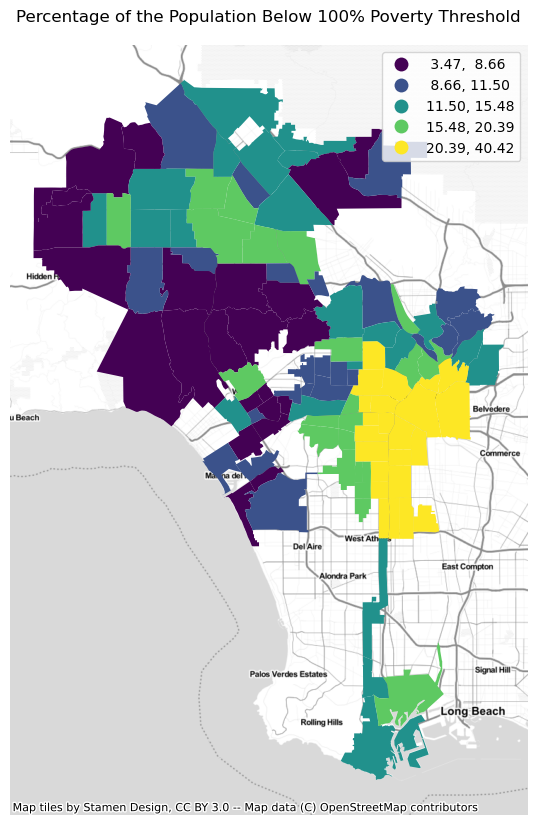

In [26]:
#Plot the data
fig, ax = plt.subplots(figsize=(20, 10))
PovertyNeighborhoods_web_mercator.plot(
                 column='Percent_Below_100',
                 legend=True, 
                 scheme='quantiles',
                 ax=ax)

# turn the axes off
ax.axis('off')

# give it a title
ax.set_title('Percentage of the Population Below 100% Poverty Threshold')

# add a basemap
ctx.add_basemap(ax, crs=3857, source=ctx.providers.Stamen.TonerLite)

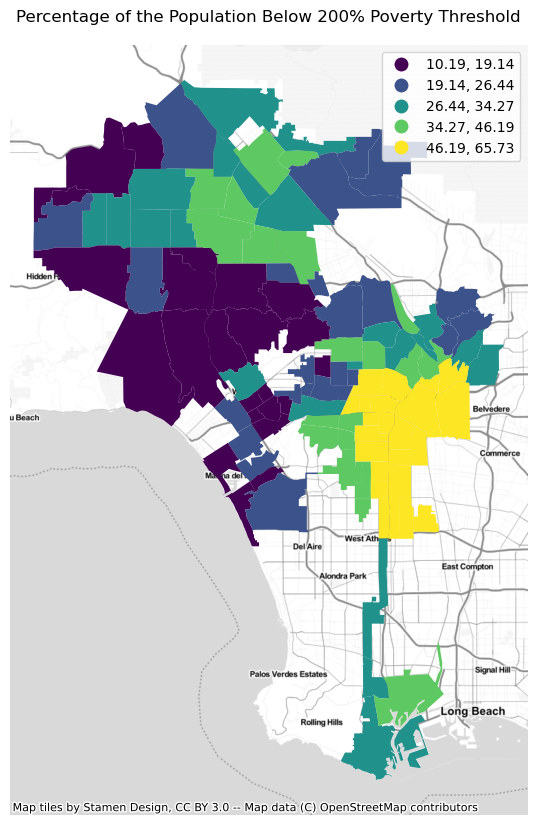

In [27]:
#Plot the data
fig, ax = plt.subplots(figsize=(20, 10))
PovertyNeighborhoods_web_mercator.plot(
                 column='Percent_Below_200',
                 legend=True, 
                 scheme='quantiles',
                 ax=ax)

# turn the axes off
ax.axis('off')

# give it a title
ax.set_title('Percentage of the Population Below 200% Poverty Threshold')

# add a basemap
ctx.add_basemap(ax, crs=3857, source=ctx.providers.Stamen.TonerLite)

### Top 10 Neighborhoods with the Highest Percentage of Population Below 100% Poverty Threshold

In [28]:
#Sort the data 
Poverty_100_Sorted = PovertyNeighborhoods.sort_values(by='Percent_Below_100',ascending = False)

In [29]:
Poverty_100_Sorted.head(10)

,geometry,Leading 0,geoid20,year,denom_known_poverty,pop_below_100_count,pop_below_100_pct,pop_below_200_count,pop_below_200_pct,Percent_Below_100,Percent_Below_200
Neighborhood,,,,,,,,,,,
University Park,"POLYGON ((-118.27974 34.01847, -118.28282 34.0...",0,72446678395,24252,26608,10754,527.036104,17490,801.677407,40.416416,65.732111
Historic South-Central,"POLYGON ((-118.28115 34.01109, -118.28111 34.0...",0,156967921048,52546,97574,30697,872.116774,60274,1621.217373,31.460225,61.772603
Vermont Knolls,"POLYGON ((-118.29142 33.95941, -118.29161 33.9...",0,60372748364,20210,43147,12868,306.713914,23158,541.001575,29.823626,53.672329
Downtown,"POLYGON ((-118.27405 34.03712, -118.27402 34.0...",0,235451964923,78819,99433,29594,1138.587113,48422,1852.641726,29.762755,48.698118
Westlake,"POLYGON ((-118.28262 34.05283, -118.28421 34.0...",0,259599937086,86903,141551,40212,1198.840528,80132,2398.912100,28.408136,56.609985
Florence,"POLYGON ((-118.28081 33.96788, -118.28081 33.9...",0,144894326548,48504,104345,29076,672.586229,60725,1385.633702,27.865255,58.196368
Pico-Union,"POLYGON ((-118.30029 34.03731, -118.30041 34.0...",0,144893220741,48504,73263,19879,659.817033,41427,1373.444337,27.133751,56.545596
Adams-Normandie,"POLYGON ((-118.30541 34.02571, -118.30890 34.0...",0,66409439227,22231,34090,9238,311.058310,17345,575.480940,27.098856,50.880023
Broadway-Manchester,"POLYGON ((-118.28127 33.92320, -118.28126 33.9...",0,120745165483,40420,90988,23915,526.435592,49159,1068.330769,26.283686,54.028004


### Top 10 Neighborhoods with the Highest Percentage of Population Below 200% Poverty Threshold

In [30]:
#Sort the data
Poverty_200_Sorted = PovertyNeighborhoods.sort_values(by='Percent_Below_200',ascending = False)

In [31]:
Poverty_200_Sorted.head(10)

,geometry,Leading 0,geoid20,year,denom_known_poverty,pop_below_100_count,pop_below_100_pct,pop_below_200_count,pop_below_200_pct,Percent_Below_100,Percent_Below_200
Neighborhood,,,,,,,,,,,
University Park,"POLYGON ((-118.27974 34.01847, -118.28282 34.0...",0,72446678395,24252,26608,10754,527.036104,17490,801.677407,40.416416,65.732111
Historic South-Central,"POLYGON ((-118.28115 34.01109, -118.28111 34.0...",0,156967921048,52546,97574,30697,872.116774,60274,1621.217373,31.460225,61.772603
South Park,"POLYGON ((-118.28051 33.99501, -118.28056 33.9...",0,90558480070,30315,67102,17512,395.888123,39419,875.955571,26.097583,58.744896
Watts,"POLYGON ((-118.23906 33.92947, -118.23998 33.9...",0,108672439007,36378,74867,19620,492.069528,43754,1057.954295,26.206473,58.442304
Central-Alameda,"POLYGON ((-118.25645 33.99483, -118.25641 33.9...",0,108671761587,36378,73718,18963,434.265940,42935,995.637461,25.723704,58.242220
Florence,"POLYGON ((-118.28081 33.96788, -118.28081 33.9...",0,144894326548,48504,104345,29076,672.586229,60725,1385.633702,27.865255,58.196368
Westlake,"POLYGON ((-118.28262 34.05283, -118.28421 34.0...",0,259599937086,86903,141551,40212,1198.840528,80132,2398.912100,28.408136,56.609985
Pico-Union,"POLYGON ((-118.30029 34.03731, -118.30041 34.0...",0,144893220741,48504,73263,19879,659.817033,41427,1373.444337,27.133751,56.545596
Broadway-Manchester,"POLYGON ((-118.28127 33.92320, -118.28126 33.9...",0,120745165483,40420,90988,23915,526.435592,49159,1068.330769,26.283686,54.028004


### Adding Neighborhood Outlines + Changing Basemap/Color Scheme

Consider creating custom bins, ie, having the percentage cutoffs equal on side-by-side maps

In [32]:
#import the data for neighborhood outlines
neighborhoods = gpd.read_file("https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/LA_Times_Neighborhoods/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson")

<AxesSubplot: >

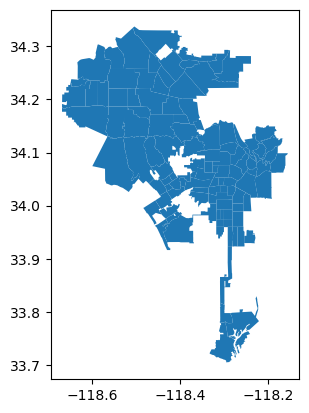

In [33]:
neighborhoods.plot()

In [34]:
#Check the CRS of the data
neighborhoods.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [35]:
#Convert the CRS to mercator projection
neighborhoods_web_mercator = neighborhoods.to_crs(epsg=3857)

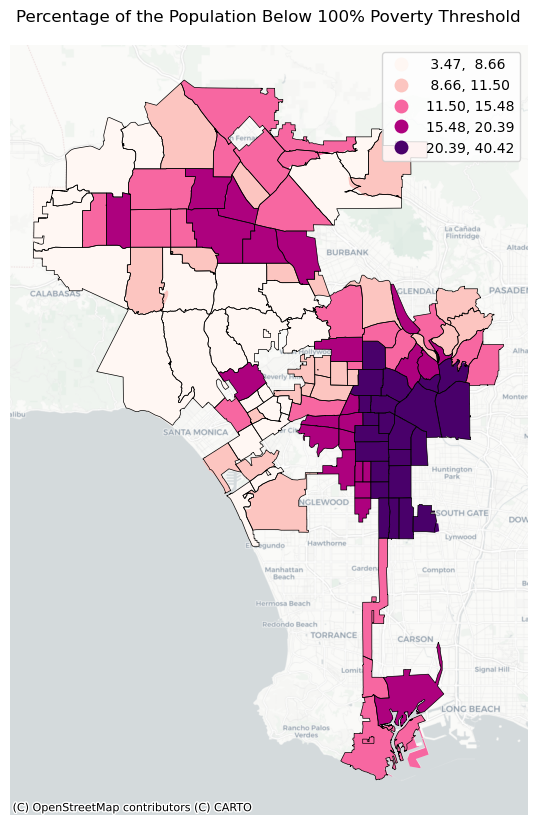

In [36]:
#Plot the data
fig, ax = plt.subplots(figsize=(20, 10))
PovertyNeighborhoods_web_mercator.plot(
                 column='Percent_Below_100',
                 cmap='RdPu',
                 legend=True, 
                 scheme='quantiles',
                 ax=ax)

neighborhoods_web_mercator.plot(
            ax=ax,                
            color = "none",        
            edgecolor = 'black',
            linewidth = 0.5,
            )

# turn the axes off
ax.axis('off')

# give it a title
ax.set_title('Percentage of the Population Below 100% Poverty Threshold')

# add a basemap
ctx.add_basemap(ax, crs=3857, source=ctx.providers.CartoDB.Positron)

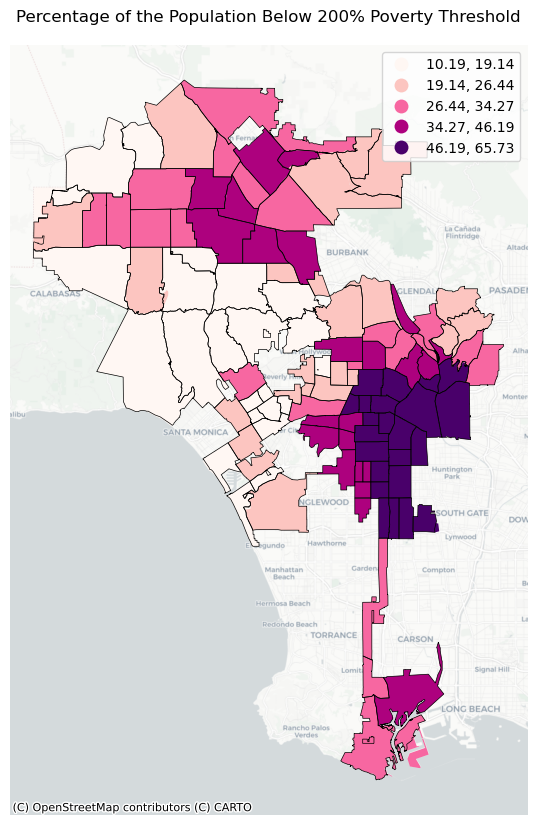

In [37]:
#Plot the data
fig, ax = plt.subplots(figsize=(20, 10))
PovertyNeighborhoods_web_mercator.plot(
                 column='Percent_Below_200',
                 cmap='RdPu',
                 legend=True, 
                 scheme='quantiles',
                 ax=ax)

neighborhoods_web_mercator.plot(
            ax=ax,                
            color = "none",        
            edgecolor = 'black',
            linewidth = 0.5,
            )

# turn the axes off
ax.axis('off')

# give it a title
ax.set_title('Percentage of the Population Below 200% Poverty Threshold')

# add a basemap
ctx.add_basemap(ax, crs=3857, source=ctx.providers.CartoDB.Positron)

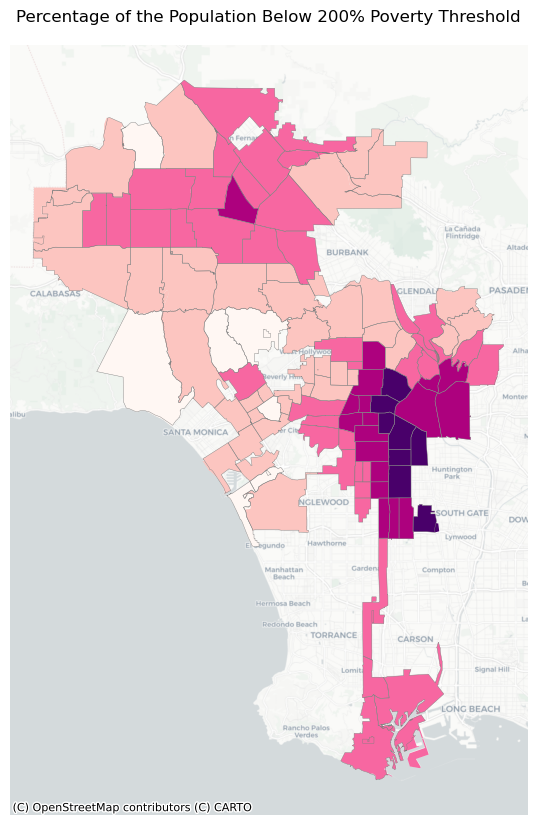

In [38]:
#Plot the data - adding a custom bin, changing the color and linewidth of the neighborhood outline, and get rid of the legend
fig, ax = plt.subplots(figsize=(20, 10))
PovertyNeighborhoods_web_mercator.plot(
                 column='Percent_Below_200',
                 cmap='RdPu',
                 legend=False, 
                 scheme="User_Defined",
                 classification_kwds=dict(bins=[14,28,42,56,70]),
                 ax=ax)

neighborhoods_web_mercator.plot(
            ax=ax,                
            color = "none",        
            edgecolor = 'grey',
            linewidth = 0.3,
            )

# turn the axes off
ax.axis('off')

# give it a title
ax.set_title('Percentage of the Population Below 200% Poverty Threshold')

# add a basemap
ctx.add_basemap(ax, crs=3857, source=ctx.providers.CartoDB.Positron)